In [78]:
import json
import matplotlib.pyplot as plt
from dataclasses import dataclass
from pathlib import Path
from omegaconf import OmegaConf
import numpy as np

In [79]:
@dataclass
class Result:
    step: int
    top10_activities: list[float]
    top10_synths: list[float] 

@dataclass
class Experiment:
    model_name: str
    compounds_budget: int
    config: OmegaConf
    path: Path
    _repeats: list

    @property
    def compounds_per_step(self):
        return self.compounds_budget // len(self._repeats[0])

    def results(self):
        steps = len(self._repeats[0])
        
        for step in range(steps):
            top10_activities = []
            top10_synths = []
            for repeat in self._repeats:
                assert repeat[step]["step"] == step
                top10_activities.append(repeat[step]["top10"])
                top10_synths.append(repeat[step]["top10_synth"])

            yield Result(
                step=step,
                top10_activities=top10_activities,
                top10_synths=top10_synths
            )

    def add_plot(self, ax, color):
        steps = range(len(self._repeats[0]))
        compounds_step = self.compounds_per_step
        x_axis = [step * compounds_step + 100 for step in steps]

        activities_mean = np.array([np.mean(result.top10_activities) for result in self.results()])
        activities_std = np.array([np.std(result.top10_activities) for result in self.results()])

        ax.plot(x_axis, activities_mean, label=self.model_name, color=color)
        ax.fill_between(x_axis, activities_mean - activities_std, activities_mean + activities_std, color=color, alpha=0.2)

In [80]:
def find_folders_with_file(root_path: str, filename: str) -> list[str]:
    folders = []
    root_path = Path(root_path)
    for path in root_path.rglob('*'):
        if path.is_file() and path.name == filename:
            folders.append(str(path.parent))
    return folders

def get_experiment(folder_path: str) -> Experiment:
    # get config from .hydra/config.yaml
    config_path = Path(folder_path) / '.hydra' / 'config.yaml'
    with open(config_path, 'r') as file:
        config = file.read()

    config = OmegaConf.create(config)
    model_name = config.model.name
    compounds_budget = config.training.compounds_budget

    loop_metrics_path = Path(folder_path) / f'{config.training.loop.name}_metrics.json'
    if not loop_metrics_path.exists():
        raise FileNotFoundError(f"Could not find {loop_metrics_path}")
    
    with open(loop_metrics_path, 'r') as file:
        metrics = json.load(file)

    return Experiment(model_name, compounds_budget, config, Path(folder_path), metrics)


In [81]:
root_search_path = "outputs"
file_to_find = "main.log"

In [82]:
folders = find_folders_with_file(root_search_path, file_to_find)

experiments = []
for folder in folders:
    try:
        experiments.append(get_experiment(folder))
    except FileNotFoundError:
        pass

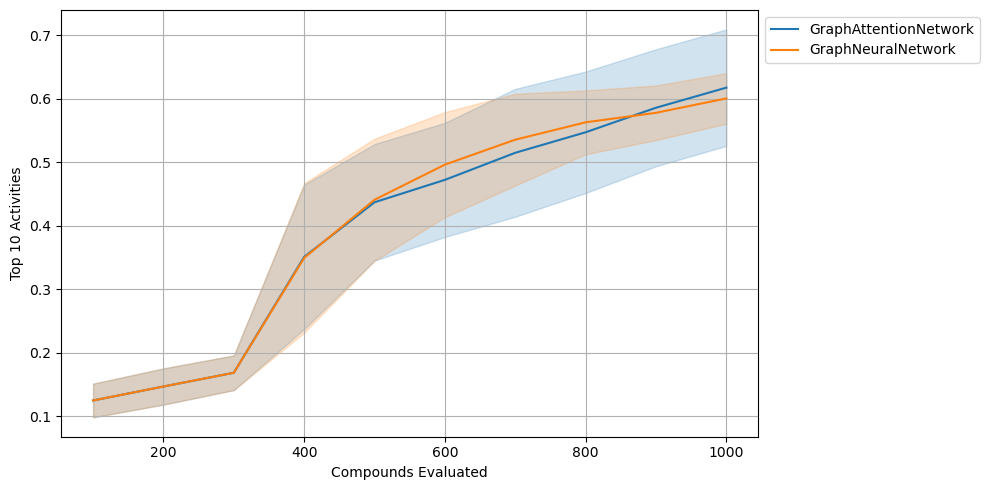

In [83]:
fig, ax = plt.subplots(figsize=(10, 5))
for i, experiment in enumerate(experiments):
    experiment.add_plot(ax, f"C{i}")

ax.set_xlabel("Compounds Evaluated")
ax.set_ylabel("Top 10 Activities")
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid()
plt.tight_layout()
plt.show()